# Tutorial 03: Ensemble methods and Decision Trees for regression

## Classification and regression

- **Classification**:  In Tutorial 02, we were training a model predicting surviving of the Titanic passengers.
    - The target variable was discrete from a set (died/survived) $y \in \{0, 1\}$ ✅.
- **Regression**: In this tutorial, we will look at the prediction of a continuous variable represented by the price of a house.
    - The problem of predicting the value of a continuous variable is called regression 📈.

![https://miro.medium.com/max/1000/1*aLxkYI8694Ysy6k7WvHbGg.png](https://miro.medium.com/max/1000/1*aLxkYI8694Ysy6k7WvHbGg.png)

Decision trees and ensemble methods can be used for both classification and regression! 🚀

## Dataset 🏘️
- In this notebook, we will work with a popular dataset from [Kaggle.com](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).
- The dataset contains data about houses and their prices. The objective is to predict **the sale price of a house** (feature **SalePrice**) based on 79 features.

The description of the dataset and the particular features can be found in the file `data_description.txt`.

```python
# Show the data description
! cat data_description.txt
```

![https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png](https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png)

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Answer to the Ultimate Question of Life, 
# the Universe, and Everything.
random_seed = 42

In [2]:
df = pd.read_csv('house-prices-train.csv')

# Data preprocessing
The first thing after loading a dataset is to view the basic information 😎.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

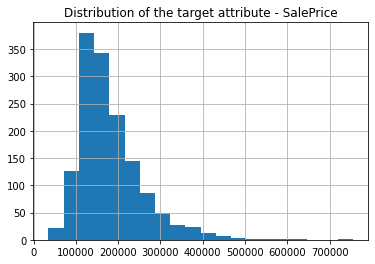

In [4]:
fig, ax = plt.subplots()
df.SalePrice.hist(bins=20)
ax.set_title("Distribution of the target attribute - SalePrice")
plt.show()

In [5]:
string_cols = df.select_dtypes(['object']).columns

df[string_cols].nunique()

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
dtype: int64

### The first attempt to use DecisionTreeRegressor

For the Titanic dataset, we have used `DecisionTreeClassifier`, which also have a variant for regression `DecisionTreeRegressor`.

This code fails due to various errors in various columns:

```
[object] - Could not convert string to float
[float64] - Input contains NaN, infinity or a value too large for dtype('float32')
```

#### How to solve this problem?
**Solution, part 1**: Convert text features (`dtype = object`) into numeric.
- Set the type of features as **categoric** (`dtype = category`). The internal representation of these features in Pandas is numeric.
- However, **nominal features** (like a name, with a *lot of unique values*) are not suitable for this representation.

```python
# Convert columns of type object to type category
for col in df.select_dtypes('object').columns:
    df[col] = df[col].astype('category')
```
Unfortunately, this will not work yet. The implementation of decision trees in `scikit-learn` does not support `dtype = category`.

**Solution, part 2**: Replace categoric variables with numbers.
- This approach is correct for **ordinal** features (ordered).
- However, for **nominal** features, we would create an artificial order of the values, which would add noise to our data.
- We can replace nominal features with so-called **dummy** features. We will use **one-hot encoding** for this.
    
The decision making, which feature is nominal and which ordinal, can be hardly automatized. An acceptable candidate for an ordinal feature is *KitchenQual* or *ExterQual*.

In [6]:
display(df.KitchenQual.unique())
display(df.ExterQual.unique())

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

According to the `data_description.txt`: Ex = Excellent, Gd = Good, TA = Typical/Average, Fa = Fair, Po = Poor. Thus, we should replace text values for numbers in a way that keeps order Po < Fa < TA < Gd < Ex.

In [7]:
print("Feature KitchenQual before remapping:")
display(df.KitchenQual.sample(5, random_state=random_seed))

kitchen_quality_map = {
    'Po' : 0,
    'Fa' : 1,
    'TA' : 2,
    'Gd' : 3,
    'Ex' : 4
}
df.KitchenQual = df.KitchenQual.replace(kitchen_quality_map)

print("Feature KitchenQual after remapping:")
display(df.KitchenQual.sample(5, random_state=random_seed))

Feature KitchenQual before remapping:


892     TA
1105    Gd
413     TA
522     TA
1036    Ex
Name: KitchenQual, dtype: object

Feature KitchenQual after remapping:


892     2
1105    3
413     2
522     2
1036    4
Name: KitchenQual, dtype: int64

The use of one-hot encoding is showcased on the feature *ExterQual*.

In [8]:
_df = df[['ExterQual']] # temporal DataFrame

print("Feature ExterQual before one-hot encoding:")
display(_df.sample(5, random_state=random_seed))

_df = pd.concat([
    _df, pd.get_dummies(_df.ExterQual, prefix=('d_ExterQual'))
], axis=1)

print("Feature ExterQual after encoding:")
display(_df.sample(5, random_state=random_seed))

Feature ExterQual before one-hot encoding:


ExterQual
892         TA
1105        Gd
413         TA
522         TA
1036        Gd

Feature ExterQual after encoding:


ExterQual  d_ExterQual_Ex  d_ExterQual_Fa  d_ExterQual_Gd  d_ExterQual_TA
892         TA               0               0               0               1
1105        Gd               0               0               1               0
413         TA               0               0               0               1
522         TA               0               0               0               1
1036        Gd               0               0               1               0

We will create a function that transforms **ordinal** columns to **numerical** values and **nominal** ones to **one-hot encoding**.

> For this moment we assume that features with less than **30 unique values** are ordinal.

In [9]:
from sklearn.preprocessing import LabelEncoder

def encode_categories(df, mappers, dummies=False):
    label_encoder = LabelEncoder() # class for replacing text features with numbers
    for col in df.select_dtypes('object').columns:
        if col not in mappers and df[col].nunique() < 30:
            df[col] = df[col].fillna('NaN') # replace misssing values with a specific string
            df[col] = label_encoder.fit_transform(df[col])
            if dummies:
                df = pd.concat([
                    df.drop(columns=[col]), pd.get_dummies(df[col], prefix=('d_' + col))
                ], axis=1)
        elif col in mappers:
            df[col] = df[col].replace(mappers[col])
    return df        

In [10]:
data = pd.read_csv('house-prices-train.csv')

# Dictionary with mapping of ordinal columns to numeric attributes
ordinal_cols_mappers = {
    'KitchenQual': {
        'Po' : 0, 
        'Fa' : 1, 
        'TA' : 2, 
        'Gd' : 3, 
        'Ex' : 4,
    }
}

data = encode_categories(data, ordinal_cols_mappers)
data = data.fillna(-1) # a simple replacament of missing values in numeric features

Zkusme to s DecisionTreeRegressor znovu.

In [11]:
dt = DecisionTreeRegressor(max_depth=3)
dt.fit(data.drop(columns=['SalePrice']), data.SalePrice)
print("Yahoooooo, the model had finished training, it 'works'!!! 🚀")

Yahoooooo, the model had finished training, it 'works'!!! 🚀


## Splitting data

The directory contains CSV files `house-prices-train.csv` a `house-prices-test.csv`. We will use `house-prices-test.csv` later. Now, we use `house-prices-train.csv` and split it into **train**, **validation** and **test** set.

In [12]:
from sklearn.model_selection import train_test_split

# Split the training dataset into 60% train
Xtrain, Xrest, ytrain, yrest = train_test_split(
    # Training columns except target, target values , magic constant, keep our output consitent
    data.drop(columns=['SalePrice']), data.SalePrice, test_size=0.4, random_state=random_seed
)

# Split the rest of the data into 0.6*0.4=24% validation, 0.4*0.4=16% test
Xtest, Xval, ytest, yval = train_test_split(
    Xrest, yrest, test_size=0.6, random_state=random_seed
)

## Decision Trees for regression

We have shown that Decision Trees can be used for classification. Now, we will use them also for regression!

### Validation metric
We have used **accuracy** in case of classification (how much samples has model predicted correctly). In the case of regression and continuous target variable, we will measure how far is the prediction from ground truth (correct value). Often used metrics are:

Name | Formula
----- | -------
MSE   | $$\frac{1}{n}\sum_{i=1}^{n}(Y_{i} - \hat{Y}_{i})^2$$
MAE   | $$\frac{1}{n}\sum_{i=1}^{n}|Y_{i} - \hat{Y}_{i}|$$
RMSLE | $$\sqrt{\frac{1}{n}\sum_{i=1}^{n}(log(Y_{i} + 1) - log(\hat{Y}_{i} + 1))^2}$$

The selection of the correct metric is essential and often also a difficult task. It may happen that the selected metric, which we are optimizing the model for, produces not precisely a model we would want. The metrics differ in several ways:
- how we can interpret them
- how easily they can (or not) be differentiated
- how they handle various data (outliers)

For example, for the metrics mentioned above:
- MSE is sensitive to outliers (strongly penalizes them)
- MAE can be easily interpreted, less sensitive to outliers
- RMSLE is sensitive to small value deviations

In [13]:
def rmsle(y_true: pd.Series, y_hat: pd.Series) -> float:
    return math.sqrt(
        metrics.mean_squared_error(
            np.log1p(y_true), np.log1p(y_hat)
        )
    )

In [14]:
param_grid = {
    'max_depth': range(1,10),
    'random_state': [random_seed]
}

param_comb = ParameterGrid(param_grid)

val_metric = []
for params in param_comb:
    dt = DecisionTreeRegressor(**params).fit(Xtrain, ytrain)
    val_metric.append(rmsle(yval, dt.predict(Xval)))

In [15]:
# Select the best parameters
best_params = param_comb[np.argmin(val_metric)]
print(f"We found the best params {best_params} with validation RMSLE {min(val_metric):.4f}.")

# Train the DecisionTreeRegressor on them
dt = DecisionTreeRegressor(**best_params).fit(Xtrain, ytrain)

We found the best params {'random_state': 42, 'max_depth': 7} with validation RMSLE 0.1853.


In [16]:
train_rmsle_tree = rmsle(ytrain, dt.predict(Xtrain))
valid_rmsle_tree = rmsle(yval, dt.predict(Xval))
print(f"RMSLE (train): \t{train_rmsle_tree:.4f}")
print(f"RMSLE (valid): \t{valid_rmsle_tree:.4f}")

RMSLE (train): 	0.1196
RMSLE (valid): 	0.1853


```python
# We should not look at this and we will not cheat!
# We still want to train other models on the training data!
test_rmsle_tree = rmsle(ytest, dt.predict(Xtest))
print(f"RMSLE (test): \t{test_rmsle_tree:.4f}")
```

## Random Forest `RandomForestRegressor`
It is built with the method **bagging** (bootstrap aggregating):
- Random Forest is trained on $n$ sets created from the training set by bootstrapping.
- Each set is used to train one Decision Tree (thus, $n$ trees will be trained).
- Outputs of particular trees are aggregated to the final prediction.
  
![img/bagging.png](img/bagging.png)

Using forest instead of tree in `sklearn` is simple:
- Replace `DecisionTreeRegressor` with `RandomForestRegressor`.
- Most of the hyperparameters are quite similar:
  * `max_depth`, maximal depth of one tree in the forest
  * `max_features`, number of features, which are taken by the greedy algorithm into account in the particular step
- New hyperparameters:
  * `n_estimators`, number of trees to train
  * `max_samples`, size of the bootstrapped training set

In [17]:
from sklearn.ensemble import RandomForestRegressor


param_grid = {
    'n_estimators': range(1, 100, 5),
    'max_depth': range(1, 5),
    'random_state': [random_seed]
}

param_comb = ParameterGrid(param_grid)

val_metric = []
for params in param_comb:
    dt = RandomForestRegressor(**params).fit(Xtrain, ytrain)
    val_metric.append(rmsle(yval, dt.predict(Xval)))

In [18]:
best_params = param_comb[np.argmin(val_metric)]
print(f"We found the best params {best_params} with validation RMSLE {min(val_metric):.4f}.")

forest_model = RandomForestRegressor(**best_params).fit(Xtrain, ytrain)

We found the best params {'random_state': 42, 'n_estimators': 61, 'max_depth': 4} with validation RMSLE 0.1722.


In [19]:
train_rmsle_forest = rmsle(ytrain, forest_model.predict(Xtrain))
valid_rmsle_forest = rmsle(yval, forest_model.predict(Xval))
print(f"RMSLE (train): \t{train_rmsle_forest:.4f}")
print(f"RMSLE (valid): \t{valid_rmsle_forest:.4f}")

RMSLE (train): 	0.1581
RMSLE (valid): 	0.1722


# Task: Use Random Forest for classification on the Titanic dataset

Your task is to beat the classification performance of the Decision Tree on the familiar Titanic dataset.

In [20]:
titanic = pd.read_csv('titanic.csv')

# We will drop these columns now (but they could be helpful!)
titanic = titanic.drop(columns=["Name", "Ticket", "Cabin"])

Data has to preprocessed:
- Use one-hot encoding for columns *Sex* and *Embarked*
    - `pd.get_dummies(titanic, ...)`
- Missing values in *Age* fill with for example median
    - it is not the best approach, but good enough for a baseline.

Do not forget that accuracy should be maximized! (unlike the RMSLE)

In [21]:
# Place your preprocessing code here :)

# Fill missing Age with median
titanic.Age.fillna(titanic.Age.median(), inplace=True)

# use one-hot encoding
for col in titanic.select_dtypes(object).columns:
    titanic = pd.concat([
        titanic.drop(col, axis=1), pd.get_dummies(titanic[col], prefix=('d_' + col))
    ], axis=1)
    
display(titanic.info())
titanic.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int64  
 1   Pclass        891 non-null    int64  
 2   Age           891 non-null    float64
 3   SibSp         891 non-null    int64  
 4   Parch         891 non-null    int64  
 5   Fare          891 non-null    float64
 6   d_Sex_female  891 non-null    uint8  
 7   d_Sex_male    891 non-null    uint8  
 8   d_Embarked_C  891 non-null    uint8  
 9   d_Embarked_Q  891 non-null    uint8  
 10  d_Embarked_S  891 non-null    uint8  
dtypes: float64(2), int64(4), uint8(5)
memory usage: 46.2 KB


None

Survived  Pclass   Age  SibSp  Parch     Fare  d_Sex_female  d_Sex_male  \
0         0       3  22.0      1      0   7.2500             0           1   
1         1       1  38.0      1      0  71.2833             1           0   
2         1       3  26.0      0      0   7.9250             1           0   
3         1       1  35.0      1      0  53.1000             1           0   
4         0       3  35.0      0      0   8.0500             0           1   

   d_Embarked_C  d_Embarked_Q  d_Embarked_S  
0             0             0             1  
1             1             0             0  
2             0             0             1  
3             0             0             1  
4             0             0             1

In [22]:
# Train/Validation split
from sklearn.model_selection import train_test_split
X, X_val, y, y_val = train_test_split(
    titanic.drop(columns=['Survived']), titanic.Survived, test_size=0.25, random_state=random_seed
)

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt = DecisionTreeClassifier(max_depth=4, criterion='gini', random_state=42)
dt.fit(X, y)

print(f'Train accuracy:\t{accuracy_score(y, dt.predict(X))}')
print(f'Validation accuracy:\t{accuracy_score(y_val, dt.predict(X_val))}')

Train accuracy:	0.844311377245509
Validation accuracy:	0.8026905829596412


It easy to achieve accuracy of $80.2\%$ on the validation set with the Decision Tree.

It is possible to achieve at least $82\%$ on the validation set with the Random Forest Classifier.
> You can get 0.5 bonus point for achieving validation accuracy over $81\%$ and another 0.5 bonus point for validation accuracy over $82\%$. **Use argument `random_state=random_seed` for reproducibility of the results.**

In [24]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {
    'n_estimators': range(1, 100, 2),
    'max_depth': range(2, 5),
    'min_samples_split': range(2, 5),
    'criterion': ['gini', 'entropy'],
    'random_state': [random_seed]
}
param_comb = ParameterGrid(param_grid)

val_acc = []
for params in param_comb:
    rf = RandomForestClassifier(**params)
    rf.fit(X, y)
    val_acc.append(accuracy_score(y_val, rf.predict(X_val)))
    
print(f'Best validation score is {np.max(val_acc)} with parameters {param_comb[np.argmax(val_acc)]}')

Best validation score is 0.8251121076233184 with parameters {'random_state': 42, 'n_estimators': 45, 'min_samples_split': 3, 'max_depth': 4, 'criterion': 'gini'}


In [25]:
rf = RandomForestClassifier(**param_comb[np.argmax(val_acc)])
rf.fit(X, y)

print(f'Train accuracy:\t{accuracy_score(y, rf.predict(X))}')
print(f'Validation accuracy:\t{accuracy_score(y_val, rf.predict(X_val))}')

Train accuracy:	0.8488023952095808
Validation accuracy:	0.8251121076233184


# Boosting - AdaBoost
AdaBoost is unlike the Random Forest built on the boosting method:
- The trees (or other ML models, called **weak learners**) are trained sequentially.
- First tree is trained on the whole dataset.
- Data is weighted according to the quality of their prediction by the last trained tree.
- Based on the weighted data, we train the following tree, which will prioritize data with higher weight.
- During prediction, all of the weak learners predict, and the final output is aggregated from these predictions.

![img/boosting.png](img/boosting_en.png)

In `sklearn` it is enough to replace class `RandomForestRegressor` with `AdaBoostRegressor`.

`AdaBoostRegressor` has to important hyperparameters:
- `base_estimator`, defines what ML model will be used as a weak learner, in our case a **decision tree**.
  - Default value is a decision tree with a depth of 3.
- `n_estimators`, the number of weak learners to train.
  - Default value is 50.

In [26]:
from sklearn.ensemble import AdaBoostRegressor

param_grid = {
    'n_estimators': range(1,100,5),
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 1],
    'random_state': [random_seed]
}

param_comb = ParameterGrid(param_grid)

val_metric = []
for params in param_comb:
    dt = AdaBoostRegressor(**params).fit(Xtrain, ytrain)
    val_metric.append(rmsle(yval, dt.predict(Xval)))

In [27]:
best_params = param_comb[np.argmin(val_metric)]
print(f"We found the best params {best_params} with validation RMSLE {min(val_metric):.4f}.")

ada_model = AdaBoostRegressor(**best_params).fit(Xtrain, ytrain)

We found the best params {'random_state': 42, 'n_estimators': 81, 'learning_rate': 0.3} with validation RMSLE 0.1840.


In [28]:
train_rmsle_ada = rmsle(ytrain, ada_model.predict(Xtrain))
valid_rmsle_ada = rmsle(yval, ada_model.predict(Xval))
print(f"RMSLE (train): \t{train_rmsle_ada:.4f}")
print(f"RMSLE (valid): \t{valid_rmsle_ada:.4f}")

RMSLE (train): 	0.1746
RMSLE (valid): 	0.1840


# Performance comparison

We will plot the results and take the best model based on the validation error.

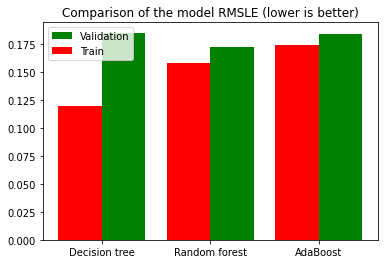

In [29]:
import matplotlib.pyplot as plt

results_val = [valid_rmsle_tree, valid_rmsle_forest, valid_rmsle_ada]
results_train = [train_rmsle_tree, train_rmsle_forest, train_rmsle_ada]

x_points_train = np.arange(len(results_val))
x_points_val = np.arange(0.4, len(results_val) + 0.4, 1)
x_points_labels = np.arange(0.2, len(results_val) + 0.2, 1)

plt.bar(x_points_val, results_val, label='Validation', color='g', width=0.4)
plt.bar(x_points_train, results_train, label='Train', color='r', width=0.4)
plt.xticks(x_points_labels, ["Decision tree", "Random forest", "AdaBoost"])
plt.title("Comparison of the model RMSLE (lower is better)")
plt.legend()
plt.show()

The best model on the validation data is the Random forest. Now we can measure the test error 📈.

In [30]:
test_rmsle_forest = rmsle(ytest, forest_model.predict(Xtest))
print(f"RMSLE (train): \t{train_rmsle_forest:.4f}")
print(f"RMSLE (valid): \t{valid_rmsle_forest:.4f}")
print(f"RMSLE (test): \t{test_rmsle_forest:.4f}")

RMSLE (train): 	0.1581
RMSLE (valid): 	0.1722
RMSLE (test): 	0.1803
